In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from datetime import time
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/Users/rebeccahe/vbase-py-utils')
from vbase_utils.stats.robust_betas import * 
from vbase_utils.stats.pit_robust_betas import * 
import matplotlib.pyplot as plt
import seaborn as sns

# Regression

In [ ]:
# This is just an example of running regressions on 2024's data and obtaining residuals
market_path = "Index Returns/Raw Returns/Market Cap Weighted/"
sqrt_path = "Index Returns/Raw Returns/Sqrt Market Cap Weighted/"
years = ['2024']
market_files = [file for file in os.listdir(market_path) if file.endswith('.csv')]
sqrt_files = [file for file in os.listdir(sqrt_path) if file.endswith('.csv')]
market_index = pd.DataFrame()
sqrt_index = pd.DataFrame()
for y in years:
    df_market = pd.read_csv(market_path+y+'.csv')
    df_sqrt = pd.read_csv(sqrt_path+y+'.csv')
    market_index = pd.concat([market_index, df_market])
    sqrt_index = pd.concat([sqrt_index, df_sqrt])
market_index.set_index('time',inplace=True)
sqrt_index.set_index('time',inplace=True)
sqrt_index.index = pd.to_datetime(sqrt_index.index,unit='ns', utc=True)
market_index.index = pd.to_datetime(market_index.index,unit='ns', utc=True)

In [ ]:
freq = '15min'
base_dir = "validityBase/stock_data/2024/"
months = ['0'+str(i) if i < 10 else str(i) for i in range(1,13)]
all_spy = pd.DataFrame()
for month in months:
    directory = base_dir + month
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    csv_files.sort()
    for file in csv_files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        df = df[df['ticker']=='SPY'] # We only want SPY data
        df['time'] = pd.to_datetime(df['window_start'],unit='ns', utc=True)
        df.set_index('time',inplace=True)
        df = df[df.index.time>=time(9, 30)]
        df = df[df.index.time<=time(16, 0)]
        df_15min = (
        df.groupby('ticker')
        .resample(freq)  # aggregating data according to freq (freq='15min')
        .agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        .reset_index()  
        )
        all_spy = pd.concat([all_spy, df_15min])
        
    all_spy.sort_values(['ticker','time'],inplace=True)
    all_spy['close'] = all_spy['close'].fillna(method='ffill')
    all_spy['close'].fillna(0,inplace=True)
    all_spy['returns'] = all_spy['close'].shift(-1) / all_spy['close'] - 1
    all_spy.fillna(0,inplace=True)
    all_spy.set_index('time',inplace=True)
    

    df_spy_rets = all_spy[['returns']]
    df_market_rets = market_index[market_index.index.isin(df_spy_rets.index)]
    df_sqrt_rets = sqrt_index[sqrt_index.index.isin(df_spy_rets.index)]
    df_spy_rets = df_spy_rets[df_spy_rets.index!=0]
    df_spy_rets.index = pd.to_datetime(df_spy_rets.index)
    result_market = pit_robust_betas(df_market_rets, df_spy_rets,min_timestamps=2,half_life=96,lambda_=0.5)
    result_sqrt = pit_robust_betas(df_sqrt_rets, df_spy_rets,min_timestamps=2,half_life=96,lambda_=0.5)
    result_market['df_asset_resids'].to_csv(f'Index Returns/Hedged Returns/Market Cap Weighted/2024/{month}_{freq}.csv')
    result_sqrt['df_asset_resids'].to_csv(f'Index Returns/Hedged Returns/Sqrt Market Cap Weighted/2024/{month}_{freq}.csv')

# Aggregating and Profiling Sentiment Features

In [ ]:
constituents = pd.read_csv('constituents.csv')
weights_df = pd.read_excel('holdings-daily-us-en-spy.xlsx', skiprows=4, skipfooter=10)

In [ ]:
cons = constituents['Symbol']
months = ['0'+str(i) if i < 10 else str(i) for i in range(1,13)]
all_factors = pd.DataFrame()
for m in months:
    st = pd.read_csv(f'sentiment/sentiment_2024_{m}.csv')
    st = st[st['symbol'].isin(cons)]
    st.rename(columns={'created_at':'time'},inplace=True)
    st['normalized_sentiment'] = st.groupby('time')['sentiment'].transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
    st['normalized_volume'] = st.groupby('time')['message_volume'].transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
    

    st['time'] = pd.to_datetime(st['time'],unit='ns', utc=True)
    st.set_index('time',inplace=True)
    st = st[st['symbol'].isin(cons)]
    st = st[st.index.time>=time(9, 30)]
    st = st[st.index.time<=time(16, 0)]
    st = st.groupby('symbol').resample(freq).last().drop('symbol',axis=1).reset_index()
    
    st['sentiment_change'] = st.groupby('symbol')['sentiment'].transform(
        lambda x: np.where(x != 0, x.shift(-1)/x - 1, 0)
    )
    st['normalized_sentiment_change'] = st.groupby('time')['sentiment_change'].transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
    st['volume_change'] = st.groupby('symbol')['message_volume'].transform(
        lambda x: np.where(x != 0, x.shift(-1)/x - 1, 0)
    )
    st['normalized_volume_change'] = st.groupby('time')['volume_change'].transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
    
    st.set_index('time',inplace=True)
    st.fillna(0,inplace=True)
    st.index = pd.to_datetime(st.index,unit='ns', utc=True)
    st = st[['symbol','normalized_sentiment','normalized_volume','normalized_sentiment_change','normalized_volume_change']]
    all_factors = pd.concat([all_factors,st])
all_factors.head()

,symbol,normalized_sentiment,normalized_volume,normalized_sentiment_change,normalized_volume_change
time,,,,,
2024-01-01 09:30:00+00:00,A,0.661308,1.741641,0.032172,0.094060
2024-01-01 09:45:00+00:00,A,0.663860,1.738942,0.093924,-0.043428
2024-01-01 10:00:00+00:00,A,0.666863,1.741576,-0.010198,-0.000902
2024-01-01 10:15:00+00:00,A,0.666950,1.742151,-0.063711,0.095675
2024-01-01 10:30:00+00:00,A,0.664935,1.741212,-0.015278,-0.040691


In [ ]:
constituents = constituents[['Symbol','GICS Sector','GICS Sub-Industry']]
weights_df = weights_df[['Name','Ticker','Weight']]
weights_df.rename(columns={'Ticker':'Symbol'},inplace=True)

spy_cons = pd.merge(weights_df,constituents,on=['Symbol'])
total_cap = 1081504.6 * 1e6 # total cap of SPY according to online sources
spy_cons['Weight_rank'] = spy_cons.groupby(['GICS Sector'])['Weight'].rank(ascending=False)
spy_cons['Normalized_Rank'] = (
    spy_cons.groupby('GICS Sector')['Weight']
    .rank(ascending=False) / spy_cons.groupby('GICS Sector')['Weight'].transform('size')
)
spy_cons['Holdings_Weight'] = spy_cons.groupby('GICS Sector')['Weight'].apply(lambda x: x / sum(x)).reset_index()['Weight']
spy_cons['Sqrt_Market_Cap'] = np.sqrt(spy_cons['Weight'] / 100 * total_cap)
spy_cons['Sqrt_Holdings_Weight'] = spy_cons.groupby('GICS Sector')['Sqrt_Market_Cap'].apply(lambda x: x / sum(x)).reset_index()['Sqrt_Market_Cap']
spy_cons.rename(columns={'Symbol':'symbol'},inplace=True)

In [ ]:
spy_cons = spy_cons[['symbol','GICS Sector','Weight','Holdings_Weight','Sqrt_Holdings_Weight']]
spy_cons

,symbol,GICS Sector,Weight,Holdings_Weight,Sqrt_Holdings_Weight
0,MSFT,Information Technology,6.922574,0.304875,0.161306
1,NVDA,Information Technology,6.905339,0.205774,0.132521
2,AAPL,Information Technology,5.818980,0.167973,0.119732
3,AMZN,Consumer Discretionary,3.911023,0.104345,0.094369
4,META,Communication Services,2.952506,0.043036,0.060604
...,...,...,...,...,...
498,ENPH,Information Technology,0.011527,0.014966,0.023222
499,CZR,Consumer Discretionary,0.011304,0.012709,0.021400
500,MHK,Consumer Discretionary,0.010719,0.012502,0.021225
501,BF.B,Consumer Staples,0.009682,0.008294,0.017288


In [ ]:
all_factors['time'] = all_factors.index
all_factors = pd.merge(spy_cons,all_factors,on='symbol')
holdings_weighted_st = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_sentiment']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_sentiment'})
holdings_weighted_st

,GICS Sector,time,normalized_sentiment
0,Communication Services,2024-01-01 09:30:00+00:00,-0.672197
1,Communication Services,2024-01-01 09:45:00+00:00,-0.673611
2,Communication Services,2024-01-01 10:00:00+00:00,-0.674141
3,Communication Services,2024-01-01 10:15:00+00:00,-0.681720
4,Communication Services,2024-01-01 10:30:00+00:00,-0.672294
...,...,...,...
377383,Utilities,2024-12-31 15:00:00+00:00,0.414379
377384,Utilities,2024-12-31 15:15:00+00:00,0.417207
377385,Utilities,2024-12-31 15:30:00+00:00,0.416172
377386,Utilities,2024-12-31 15:45:00+00:00,0.441396


In [ ]:
holdings_weighted_vo = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_volume']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_volume'})
holdings_weighted_sc = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_sentiment_change']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_sentiment_change'})
holdings_weighted_vc = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_volume_change']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_volume_change'})

In [ ]:
sqrt_weighted_st = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_sentiment']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_sentiment'})
sqrt_weighted_vo = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_volume']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_volume'})
sqrt_weighted_sc = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_sentiment_change']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_sentiment_change'})
sqrt_weighted_vc = all_factors.groupby(['GICS Sector','time']).apply(lambda x:sum(x['normalized_volume_change']*x['Weight']/sum(x['Weight']))).reset_index().rename(columns={0:'normalized_volume_change'})

In [ ]:
market_path = "Index Returns/Hedged Returns/Market Cap Weighted/"
sqrt_path = "Index Returns/Hedged Returns/Sqrt Market Cap Weighted/"
years = ['2024/'] # Right now I'm only using 2024's data
months = ['0'+str(i) if i < 10 else str(i) for i in range(1,13)]
market_files = [file for file in os.listdir(market_path) if file.endswith('.csv')]
sqrt_files = [file for file in os.listdir(sqrt_path) if file.endswith('.csv')]
market_index = pd.DataFrame()
sqrt_index = pd.DataFrame()
for y in years:
    for m in months:
        df_market = pd.read_csv(market_path+y+m+'.csv')
        df_sqrt = pd.read_csv(sqrt_path+y+m+'.csv')
        market_index = pd.concat([market_index, df_market])
        sqrt_index = pd.concat([sqrt_index, df_sqrt])  

market_index.set_index('time',inplace=True)
sqrt_index.set_index('time',inplace=True)
market_index.dropna(inplace=True)
sqrt_index.dropna(inplace=True)

In [ ]:
market_index = market_index.stack().reset_index()
market_index.columns = ['time','GICS Sector','returns']
market_index['time'] = pd.to_datetime(market_index['time'],unit='ns', utc=True)
market_index.sort_values(['GICS Sector','time'],inplace=True)
market_index

,time,GICS Sector,returns
0,2021-01-04 10:15:00+00:00,Communication Services,-0.004796
11,2021-01-04 10:30:00+00:00,Communication Services,0.001643
22,2021-01-04 10:45:00+00:00,Communication Services,-0.001079
33,2021-01-04 11:00:00+00:00,Communication Services,-0.000672
44,2021-01-04 11:15:00+00:00,Communication Services,-0.000954
...,...,...,...
323960,2025-06-02 15:00:00+00:00,Utilities,-0.001258
323971,2025-06-02 15:15:00+00:00,Utilities,0.000440
323982,2025-06-02 15:30:00+00:00,Utilities,0.000353
323993,2025-06-02 15:45:00+00:00,Utilities,0.001477


In [ ]:
market_index = pd.merge(market_index,holdings_weighted_st,on=['time','GICS Sector'])
market_index = pd.merge(market_index,holdings_weighted_vo,on=['time','GICS Sector'])
market_index = pd.merge(market_index,holdings_weighted_sc,on=['time','GICS Sector'])
market_index = pd.merge(market_index,holdings_weighted_vc,on=['time','GICS Sector'])
market_index

,time,GICS Sector,returns,normalized_sentiment,normalized_volume,normalized_sentiment_change,normalized_volume_change
0,2024-01-02 10:15:00+00:00,Communication Services,0.001674,-0.752251,-0.443431,-0.085088,-0.097166
1,2024-01-02 10:30:00+00:00,Communication Services,-0.001277,-0.762046,-0.454263,-0.063290,-0.082351
2,2024-01-02 10:45:00+00:00,Communication Services,0.004081,-0.761545,-0.458807,0.028012,-0.106552
3,2024-01-02 11:00:00+00:00,Communication Services,-0.002970,-0.760410,-0.466783,-0.064315,0.037861
4,2024-01-02 11:15:00+00:00,Communication Services,-0.000857,-0.761618,-0.466879,-0.176628,-0.153962
...,...,...,...,...,...,...,...
74432,2024-12-31 15:00:00+00:00,Utilities,-0.000143,0.414379,0.339893,-0.008262,-0.151111
74433,2024-12-31 15:15:00+00:00,Utilities,-0.000840,0.417207,0.339004,-0.103340,-0.078673
74434,2024-12-31 15:30:00+00:00,Utilities,-0.000904,0.416172,0.338565,0.346511,-0.044365
74435,2024-12-31 15:45:00+00:00,Utilities,0.004523,0.441396,0.338820,-0.150005,-0.056170


In [ ]:
sqrt_index = sqrt_index.stack().reset_index()
sqrt_index.columns = ['time','GICS Sector','returns']
sqrt_index['time'] = pd.to_datetime(sqrt_index['time'],unit='ns', utc=True)
sqrt_index

,time,GICS Sector,returns
0,2021-01-04 10:15:00+00:00,Communication Services,-0.003929
1,2021-01-04 10:15:00+00:00,Consumer Discretionary,-0.000994
2,2021-01-04 10:15:00+00:00,Consumer Staples,0.000603
3,2021-01-04 10:15:00+00:00,Energy,0.000159
4,2021-01-04 10:15:00+00:00,Financials,-0.000805
...,...,...,...
324000,2025-06-02 16:00:00+00:00,Industrials,0.003578
324001,2025-06-02 16:00:00+00:00,Information Technology,0.009382
324002,2025-06-02 16:00:00+00:00,Materials,-0.016059
324003,2025-06-02 16:00:00+00:00,Real Estate,0.003151


In [ ]:
sqrt_index = pd.merge(sqrt_index,sqrt_weighted_st,on=['time','GICS Sector'])
sqrt_index = pd.merge(sqrt_index,sqrt_weighted_vo,on=['time','GICS Sector'])
sqrt_index = pd.merge(sqrt_index,sqrt_weighted_sc,on=['time','GICS Sector'])
sqrt_index = pd.merge(sqrt_index,sqrt_weighted_vc,on=['time','GICS Sector'])
sqrt_index

,time,GICS Sector,returns,normalized_sentiment,normalized_volume,normalized_sentiment_change,normalized_volume_change
0,2024-01-02 10:15:00+00:00,Communication Services,0.001785,-0.752251,-0.443431,-0.085088,-0.097166
1,2024-01-02 10:15:00+00:00,Consumer Discretionary,-0.000732,-0.234614,-0.045184,-0.089435,-0.079542
2,2024-01-02 10:15:00+00:00,Consumer Staples,0.002035,-0.496021,0.089577,-0.124938,-0.090878
3,2024-01-02 10:15:00+00:00,Energy,-0.003415,-0.731100,-0.198390,-0.093291,-0.000615
4,2024-01-02 10:15:00+00:00,Financials,-0.000256,-0.298555,0.376305,-0.156800,-0.071573
...,...,...,...,...,...,...,...
74432,2024-12-31 16:00:00+00:00,Industrials,0.008044,0.123687,0.233831,0.000000,0.000000
74433,2024-12-31 16:00:00+00:00,Information Technology,-0.000230,-0.361420,-1.383983,0.000000,0.000000
74434,2024-12-31 16:00:00+00:00,Materials,-0.000741,0.034708,0.391546,0.000000,0.000000
74435,2024-12-31 16:00:00+00:00,Real Estate,-0.000047,0.225362,0.428329,0.000000,0.000000


In [ ]:
def calculate_spearman(group, feature):
    """Compute Spearman correlation between sentiment rank and future return rank."""
    group = group.dropna()
    if len(group) < 2:  # Need at least 2 observations
        return np.nan
    sentiment_rank = group[feature].rank()
    return_rank = group[f"returns"].rank()
    # Spearman correlation
    corr, _ = spearmanr(sentiment_rank, return_rank)
    return corr

def long_short_by_horizon(df, feature, n_deciles=10):
    df['decile'] = df.groupby('time')[feature].transform(lambda x: pd.qcut(x, n_deciles, labels=False, duplicates='drop'))
    decile_returns = df.groupby(['time', 'decile'])['returns'].mean().unstack()
    ls_return = decile_returns[n_deciles-1] - decile_returns[0]  # Long top, short bottom
        
    # Store mean return and t-stat
    mean_return = ls_return.mean()
    t_stat = mean_return / (ls_return.std() / (len(ls_return)**0.5))
    
    return mean_return, t_stat, ls_return, decile_returns, df

results_corr = []
results_stats = {}
results_returns = []
decile_returns_dic = {}

df = market_index.copy()
features = ['normalized_sentiment','normalized_volume','normalized_sentiment_change','normalized_volume_change']
for f in features:
    corr_series = (
    df.groupby("time")
    .apply(lambda x: calculate_spearman(x, f))
    .rename(f)
    )
     
    results_corr.append(corr_series)
    mean_return, t_stat,ls_return, decile_returns, df = long_short_by_horizon(df,f, 5)
    decile_returns_dic[f] = decile_returns
    results_stats[f] = (mean_return, t_stat)
    results_returns.append(ls_return.rename(f"returns_{f}"))
    
corr_df = pd.concat(results_corr, axis=1)
results_returns = pd.concat(results_returns, axis=1)
results_long_short = pd.DataFrame(results_stats, index=['Return', 't-stat']).T

In [ ]:
decile_returns_mean = {}
for key, value in decile_returns_dic.items():
    mean_returns = value.mean().reset_index()
    mean_returns.columns = ['Quantile', 'Return']
    decile_returns_mean[key] = mean_returns

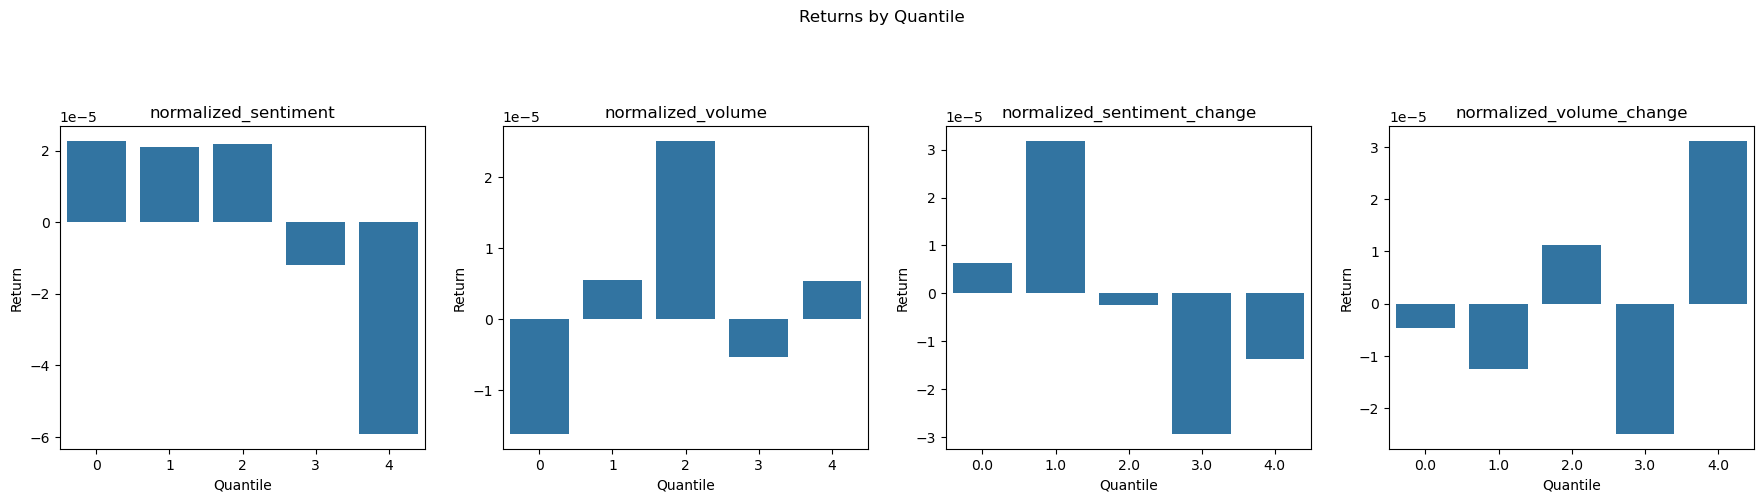

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(18,5))
fig.suptitle('Returns by Quantile', y=1.02)
i = 0
for f in features:
    sns.barplot(decile_returns_mean[f],
                x='Quantile',
                y='Return',
                ax=axes[i])
    axes[i].set_title(f)
    i += 1
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0) 

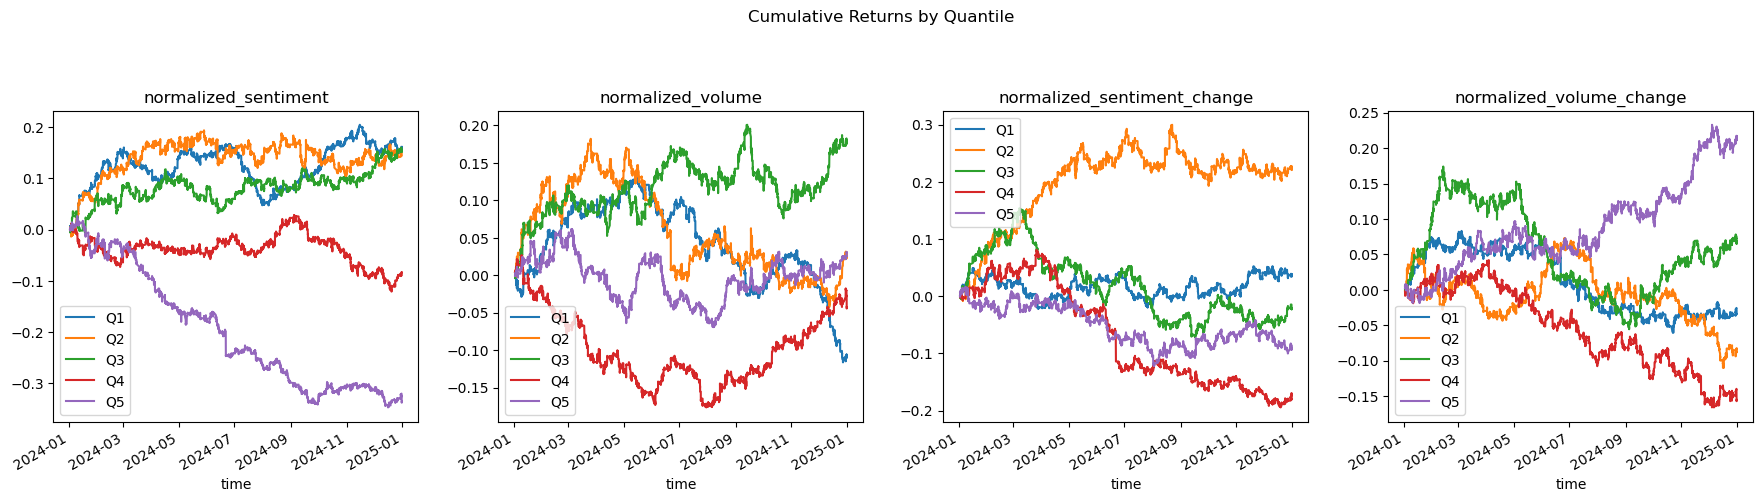

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(18,5))
fig.suptitle('Cumulative Returns by Quantile', y=1.02)
i = 0
for f in features:
    plt.subplot(1,4,i+1)
    for j in range(5):
        ((decile_returns_dic[f] + 1).cumprod() - 1)[j].plot(label=f'Q{j+1}')
    axes[i].set_title(f)
    i += 1
    plt.legend()
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0) 

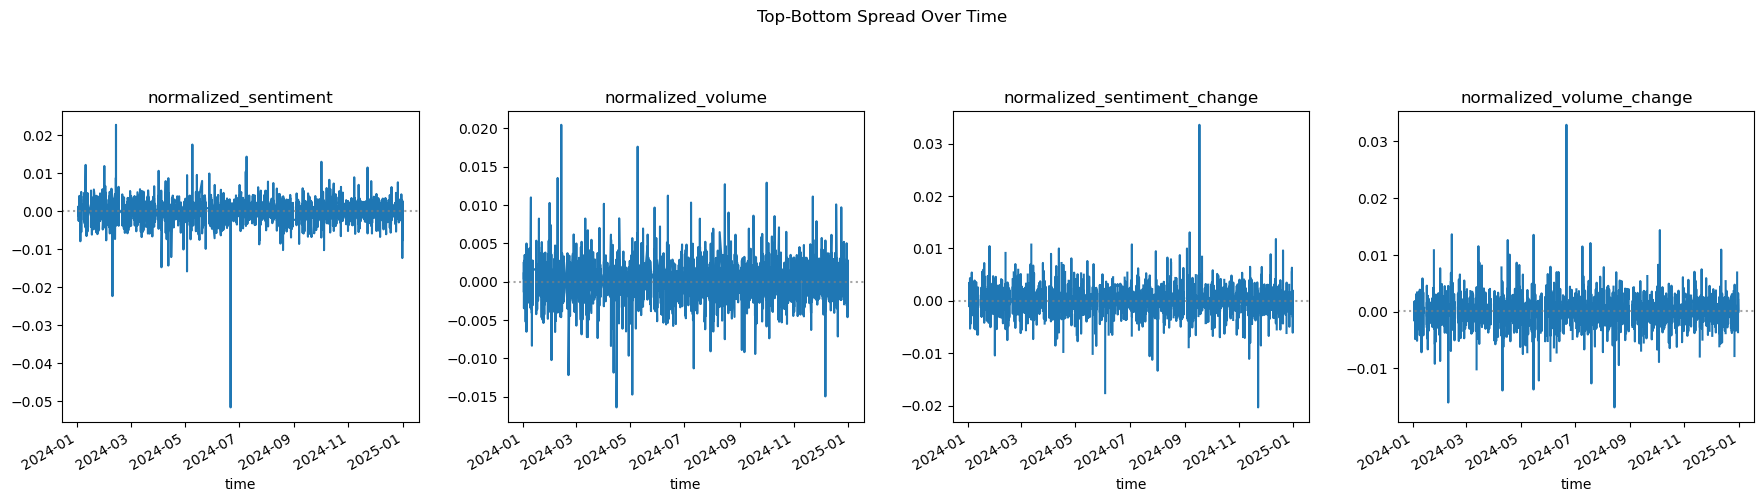

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(18,5))
fig.suptitle('Top-Bottom Spread Over Time', y=1.02)
i = 0
features = results_returns.columns
for f in features:
    plt.subplot(1,4,i+1)
    results_returns[f].plot()
    plt.axhline(y=results_returns.mean()[f], color='gray', linestyle=':', alpha=0.7)
    axes[i].set_title(f[8:])
    i += 1
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

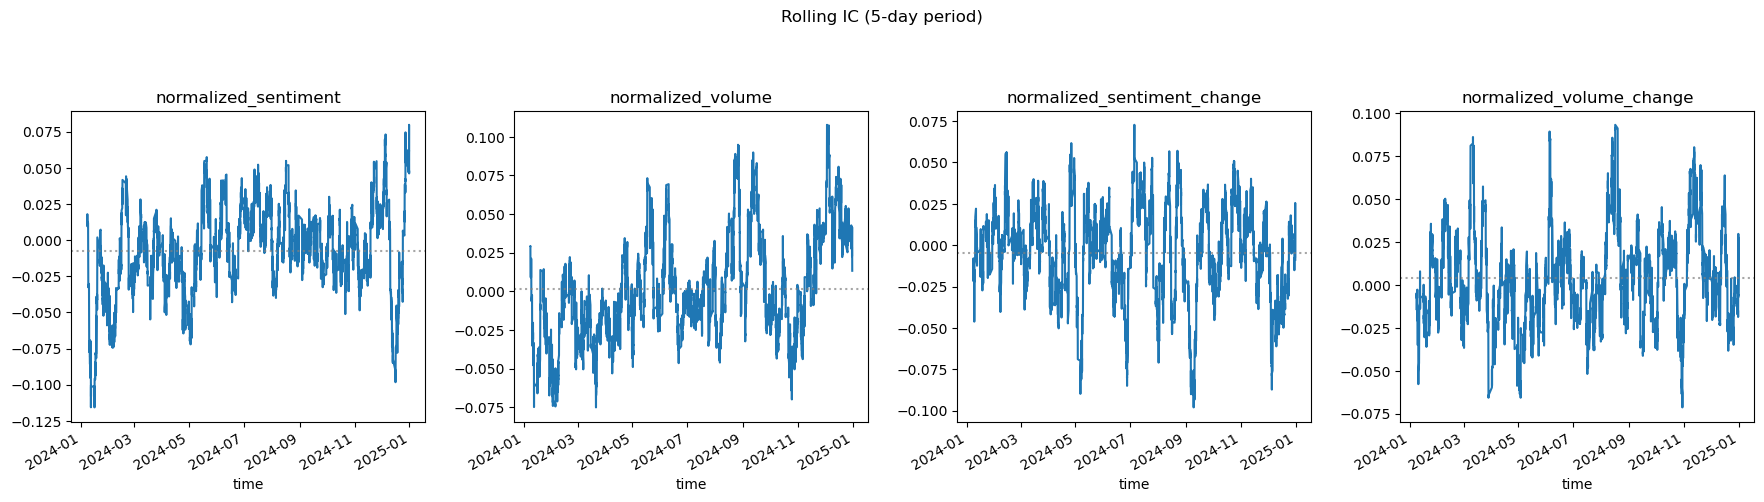

In [ ]:
fig, axes = plt.subplots(1, 4,figsize=(18,5))
fig.suptitle('Rolling IC (5-day period)', y=1.02)
i = 0
features = corr_df.columns
corr_df_roll = corr_df.fillna(0).rolling(120).mean()
for f in features:
    plt.subplot(1,4,i+1)
    corr_df_roll[f].plot().plot()
    plt.axhline(y=corr_df.mean()[f], color='gray', linestyle=':', alpha=0.7)
    axes[i].set_title(f)
    i += 1
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)